<a href="https://colab.research.google.com/github/queenakki/venoscan/blob/main/venoscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow numpy matplotlib opencv-python scikit-learn


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report


**Dataset Preparation and Data Augmentation**

In [ ]:
# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
TRAIN_DIR ='/content/drive/MyDrive/apro/train'    # Path to training data
TEST_DIR = '/content/drive/MyDrive/apro/test'      # Path to testing data

# Data Augmentation and Rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split 20% for validation
)

# Load the train dataset (80% training)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

# Load the validation dataset (20% validation)
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# No data augmentation for the test dataset, just rescale pixel values
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test dataset
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 1372 images belonging to 2 classes.
Found 341 images belonging to 2 classes.
Found 278 images belonging to 2 classes.


**Load Pre-trained DenseNet Model**

In [ ]:
# Load the DenseNet121 model pre-trained on ImageNet, excluding the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the DenseNet model
x = base_model.output
x = GlobalAveragePooling2D()(x)           # Global average pooling layer
x = Dense(1024, activation='relu')(x)     # Dense layer with 1024 units
predictions = Dense(1, activation='sigmoid')(x)  # Final binary classification layer

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base layers of DenseNet121 (they won't be updated during training)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with Adam optimizer and binary cross-entropy loss
# Compile the model with Adam optimizer and binary cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 8,088,129 (30.85 MB)

 Trainable params: 1,050,625 (4.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

**Train the Model**

In [ ]:
# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True) # Changed the file extension to .keras

# Train the model
history = model.fit(
    train_generator,
    epochs=4,                          # Number of training epochs
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 447s 9s/step - accuracy: 0.6633 - loss: 0.7986 - val_accuracy: 0.7781 - val_loss: 0.4438
Epoch 2/4
 1/42 ━━━━━━━━━━━━━━━━━━━━ 5:32 8s/step - accuracy: 0.6562 - loss: 0.5229

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - accuracy: 0.6562 - loss: 0.5229 - val_accuracy: 0.6190 - val_loss: 0.6763
Epoch 3/4
42/42 ━━━━━━━━━━━━━━━━━━━━ 365s 9s/step - accuracy: 0.8094 - loss: 0.3938 - val_accuracy: 0.8062 - val_loss: 0.4138
Epoch 4/4
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 224ms/step - accuracy: 0.7500 - loss: 0.4361 - val_accuracy: 0.8571 - val_loss: 0.4021


**Fine-tune the Model**

In [ ]:
# Unfreeze all the layers of DenseNet for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# Fine-tune the model
history_finetune = model.fit(
    train_generator,
    epochs=4,                           # Additional epochs for fine-tuning
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/4
42/42 ━━━━━━━━━━━━━━━━━━━━ 1398s 31s/step - accuracy: 0.9444 - loss: 0.1415 - val_accuracy: 0.9000 - val_loss: 0.2755
Epoch 2/4
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 142ms/step - accuracy: 0.9375 - loss: 0.1904 - val_accuracy: 0.9524 - val_loss: 0.1389
Epoch 3/4
42/42 ━━━━━━━━━━━━━━━━━━━━ 1322s 30s/step - accuracy: 0.9750 - loss: 0.0729 - val_accuracy: 0.8188 - val_loss: 0.5757
Epoch 4/4
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 1.0000 - loss: 0.0206 - val_accuracy: 0.9524 - val_loss: 0.4223


** Evaluate the Model**

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')


9/9 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - accuracy: 0.8893 - loss: 0.3119
Test Accuracy: 0.8777


Detailed Evaluation with Confusion Matrix


In [ ]:
# Get true labels and predicted labels for the test set
test_generator.reset()  # Reset the generator to avoid random shuffling
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.round(y_pred).astype(int)  # Convert probabilities to binary classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print('Confusion Matrix:\n', cm)

# Classification report
target_names = ['Non-venomous', 'Venomous']
print('Classification Report:\n', classification_report(y_true, y_pred_classes, target_names=target_names))


9/9 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step
Confusion Matrix:
 [[123  15]
 [ 19 121]]
Classification Report:
               precision    recall  f1-score   support

Non-venomous       0.87      0.89      0.88       138
    Venomous       0.89      0.86      0.88       140

    accuracy                           0.88       278
   macro avg       0.88      0.88      0.88       278
weighted avg       0.88      0.88      0.88       278



Plot Training and Validation Curves

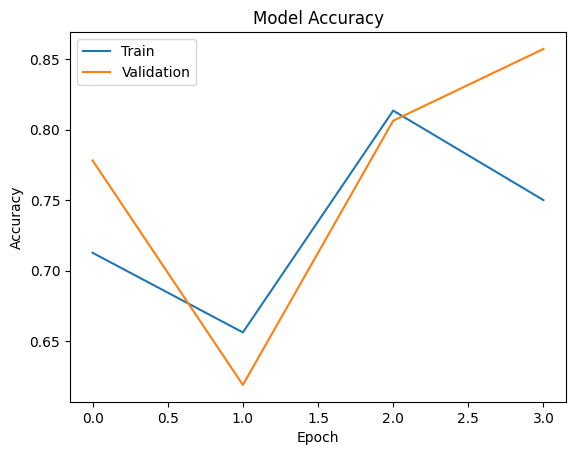

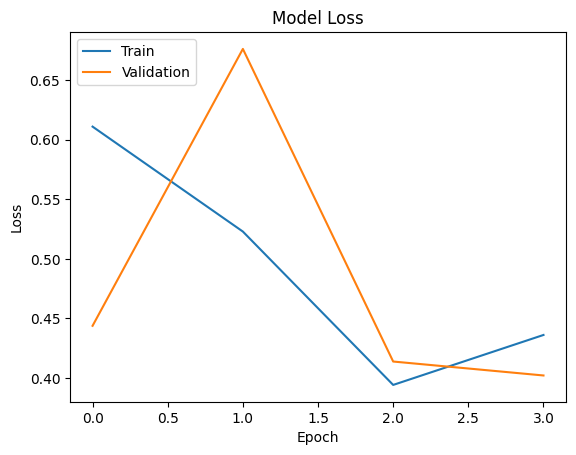

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
The snake in the image is: Venomous


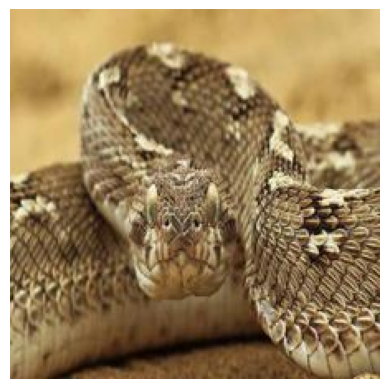

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the trained model
model = load_model('venomous_snake_classifier.h5')

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize the image
    img_array = image.img_to_array(img) / 255.0             # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)           # Add batch dimension
    return img_array

# Function to predict the class of the snake image
def predict_snake_image(img_path):
    img_array = preprocess_image(img_path)  # Preprocess the image
    prediction = model.predict(img_array)   # Get the prediction probability

    # Interpret the prediction result
    if prediction[0] > 0.5:
        result = "Venomous"
    else:
        result = "Non-venomous"

    return result

# Function to display the image
def display_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Load and resize the image
    plt.imshow(img)                                         # Display the image
    plt.axis('off')                                        # Turn off axis labels
    plt.show()

# Path to the snake image to test
image_path = '/content/drive/MyDrive/apro/test/Venomous/Venomous_10.jpg'  # Replace with the path to your test image

# Predict and print the result
result = predict_snake_image(image_path)
print(f'The snake in the image is: {result}')

# Display the image
display_image(image_path)


Found 278 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.8752 - loss: 0.3162
Validation Loss: 0.31277763843536377
Validation Accuracy: 0.8776978254318237
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
The snake in the image is: Venomous


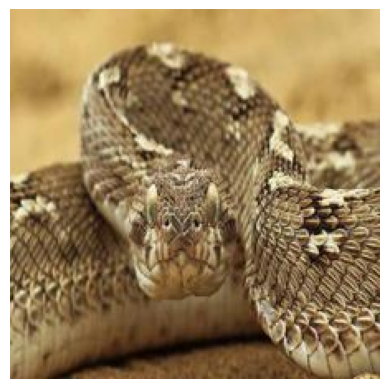

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = load_model('venomous_snake_classifier.h5')

# Compile the model to ensure metrics are built
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Prepare the validation data generator
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/apro/test',  # Your validation data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Evaluate the model
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_accuracy}')

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize the image
    img_array = image.img_to_array(img) / 255.0             # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)           # Add batch dimension
    return img_array

# Function to predict the class of the snake image
def predict_snake_image(img_path):
    img_array = preprocess_image(img_path)  # Preprocess the image
    prediction = model.predict(img_array)   # Get the prediction probability

    # Interpret the prediction result
    if prediction[0] > 0.5:
        result = "Venomous"
    else:
        result = "Non-venomous"

    return result

# Function to display the image
def display_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Load and resize the image
    plt.imshow(img)                                         # Display the image
    plt.axis('off')                                        # Turn off axis labels
    plt.show()

# Path to the snake image to test
image_path = '/content/drive/MyDrive/apro/test/Venomous/Venomous_10.jpg'  # Replace with the path to your test image

# Predict and print the result
result = predict_snake_image(image_path)
print(f'The snake in the image is: {result}')

# Display the image
display_image(image_path)


In [ ]:
# Save the final model
model.save('venomous_snake_classifier.h5')


In [ ]:
from google.colab import files
files.download('/content/dmajor.h5')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>